In [1]:
# Import libraries
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import numpy as np

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# nltk
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

C:\Users\gchoo\anaconda3\envs\dl4nlp\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\gchoo\anaconda3\envs\dl4nlp\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('Data/airline_labelled.csv',parse_dates=['date'])

In [3]:
df.head()

,airline_name,author,date,content,dominant_topic
0,british airways,russ king,1970-01-01,sin-lhr ba12 b747-436 first class. old aircraf...,0.0
1,jet airways,mike vaz,2007-04-14,stansted to las vegas return. check-in for bot...,0.0
2,jet airways,j patton,2007-04-14,stn-las-stn very enjoyable trip on both flight...,0.0
3,jet airways,andres mesa,2007-04-19,stn-las-stn. slow check-in resulted from repet...,0.0
4,tacv cabo,j van den berg,2007-04-19,all domestic flights (5 in total) were on time...,0.0


In [4]:
df.shape

(80520, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80520 entries, 0 to 80519
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   airline_name    80520 non-null  object        
 1   author          80520 non-null  object        
 2   date            80520 non-null  datetime64[ns]
 3   content         80520 non-null  object        
 4   dominant_topic  80520 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 3.1+ MB


In [6]:
# Check for null
df.isnull().sum()

airline_name      0
author            0
date              0
content           0
dominant_topic    0
dtype: int64

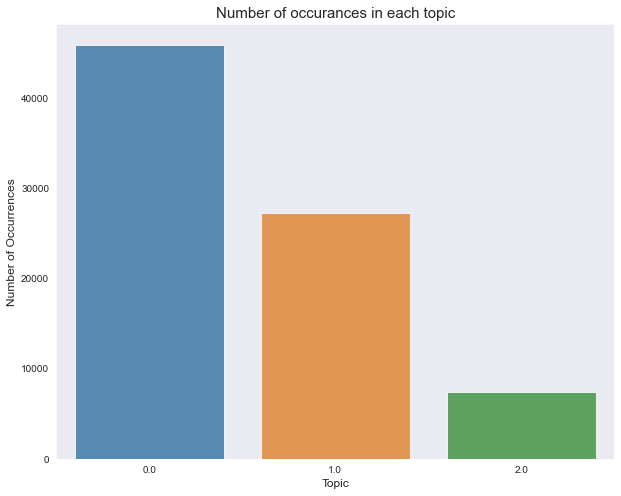

In [7]:
topicvalue = df['dominant_topic'].value_counts()
plt.figure(figsize=[10,8])
sns.set_style("dark")
sns.barplot(topicvalue.index, topicvalue.values, alpha=0.8)
plt.title('Number of occurances in each topic',fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Topic', fontsize=12)
plt.show()

In [9]:
# baseline score
df['dominant_topic'].value_counts(normalize=True)

0.0    0.570529
1.0    0.337928
2.0    0.091542
Name: dominant_topic, dtype: float64

### Data Cleaning

In [8]:
# Keep only alphabet, digit and space:
df['content'] = df['content'].map(lambda s: re.sub(r'[\W_]+', ' ', s))
df.head()

,airline_name,author,date,content,dominant_topic
0,british airways,russ king,1970-01-01,sin lhr ba12 b747 436 first class old aircraft...,0.0
1,jet airways,mike vaz,2007-04-14,stansted to las vegas return check in for both...,0.0
2,jet airways,j patton,2007-04-14,stn las stn very enjoyable trip on both flight...,0.0
3,jet airways,andres mesa,2007-04-19,stn las stn slow check in resulted from repeti...,0.0
4,tacv cabo,j van den berg,2007-04-19,all domestic flights 5 in total were on time t...,0.0


In [9]:
# Remove non-english words
import nltk
words = set(nltk.corpus.words.words())

for i, sent in enumerate(df.loc[:,'content']):
    " ".join(w for w in nltk.wordpunct_tokenize(sent) \
                                if w.lower() in words or not w.isalpha())

In [10]:
# Sanity check
df.head()

,airline_name,author,date,content,dominant_topic
0,british airways,russ king,1970-01-01,sin lhr ba12 b747 436 first class old aircraft...,0.0
1,jet airways,mike vaz,2007-04-14,stansted to las vegas return check in for both...,0.0
2,jet airways,j patton,2007-04-14,stn las stn very enjoyable trip on both flight...,0.0
3,jet airways,andres mesa,2007-04-19,stn las stn slow check in resulted from repeti...,0.0
4,tacv cabo,j van den berg,2007-04-19,all domestic flights 5 in total were on time t...,0.0


### Pre-processing

In [11]:
# Number of reviews before year 2018
print(len(df[df['date'] <= '2017-12-31']))

# Number of reviews for year 2018 onwards
print(len(df[df['date'] > '2017-12-31']))

65199
15321


In [12]:
# Before Year 2018
df[df['date'] <= '2017-12-31']['dominant_topic'].value_counts(normalize=True)

0.0    0.620868
1.0    0.285802
2.0    0.093330
Name: dominant_topic, dtype: float64

In [13]:
# Year 2018 onwards
df[df['date'] > '2017-12-31']['dominant_topic'].value_counts(normalize=True)

1.0    0.559755
0.0    0.356308
2.0    0.083937
Name: dominant_topic, dtype: float64

In [14]:
# test to train ratio
len(df[df['date'] > '2017-12-31']) / len(df[df['date'] <= '2017-12-31'])

0.23498826669120693

In [15]:
# Split train and test by dates
train = df[df['date'] <= '2017-12-31']
test = df[df['date'] > '2017-12-31']

In [16]:
# Train-test-split
X_train = train['content']
y_train = train['dominant_topic']
X_test = test['content']
y_test = test['dominant_topic']

## Modelling

### Using LSA and Logistic Regression. 

Words are represented as high-dimensional vectors in this semantic space. SVD will reduce dimensionality and remove noise.
We will be tuning the SVD to get the optimal components to use for predicting the datas

![](Image/SVD.png)

In [17]:
# instantiate
tvec = TfidfVectorizer(stop_words='english')
svd = TruncatedSVD()
lr = LogisticRegression(max_iter=1000)

In [18]:
# Setup pipeline
pipe_lsa = make_pipeline(tvec,svd,lr)

In [19]:
# Set the pipe params
pipe_lsa_params = {
    'truncatedsvd__n_components': [500,1000],
    'logisticregression__C': [1.0,0.9]   
}

In [20]:
# Instantiate gridsearchCV
gs_lsa = GridSearchCV(pipe_lsa,
                     param_grid=pipe_lsa_params,
                     cv=5,
                     verbose=1)

In [21]:
# Fit gridsearch
gs_lsa.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 24.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('truncatedsvd', TruncatedSVD()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [1.0, 0.9],
                         'truncatedsvd__n_components': [500, 1000]},
             verbose=1)

In [22]:
# Gridsearch best score
gs_lsa.best_score_

0.9267474864222811

In [23]:
# Get the best hyperparameters
gs_lsa.best_params_

{'logisticregression__C': 1.0, 'truncatedsvd__n_components': 1000}

In [24]:
# Score model on training set
gs_lsa.score(X_train,y_train)

0.9409193392536696

In [25]:
# Score model on testing set
gs_lsa.score(X_test,y_test)

0.9381894132236799

In [26]:
gs_lsa_model = gs_lsa.best_estimator_

### Terms in Concepts

In [28]:
vectorizer = gs_lsa_model.named_steps['tfidfvectorizer']
lsa = gs_lsa_model.named_steps['truncatedsvd']

In [29]:
# Import terms in each concepts
terms = vectorizer.get_feature_names()
for i, comp in enumerate(lsa.components_):
    termsInComp = zip(terms,comp)
    sortedTerms = sorted(termsInComp, key=lambda x: x[1], reverse=True)[:10]
    print("Concept %d" % i)
    for term in sortedTerms:
        print(term[0])
    print(" ")

Concept 0
flight
good
service
time
food
seats
seat
crew
staff
class
 
Concept 1
flight
hours
told
delayed
airport
gate
plane
cancelled
day
spirit
 
Concept 2
class
business
economy
seat
lounge
seats
premium
told
flat
pay
 
Concept 3
seats
seat
pay
extra
bag
airline
carry
room
air
leg
 
Concept 4
air
canada
flight
rouge
entertainment
hours
airlines
airline
toronto
fly
 
Concept 5
seat
flight
seats
plane
canada
air
rouge
economy
meal
crew
 
Concept 6
air
canada
rouge
toronto
check
staff
boarding
business
luggage
france
 
Concept 7
london
airways
cabin
staff
crew
ba
dubai
poor
emirates
passengers
 
Concept 8
good
seats
plane
staff
return
leg
flights
room
food
hours
 
Concept 9
good
staff
china
check
seat
guangzhou
entertainment
food
southern
singapore
 
Concept 10
plane
crew
cabin
seats
staff
great
airlines
new
flew
friendly
 
Concept 11
flight
seat
excellent
great
check
comfortable
singapore
staff
return
booked
 
Concept 12
economy
china
guangzhou
staff
southern
premium
flights
beijing
c

Concept 107
frontier
quite
gatwick
denver
boarding
little
helpful
cost
aircraft
city
 
Concept 108
ok
got
drinks
sydney
best
attendants
worst
airways
way
small
 
Concept 109
ok
san
clean
poor
francisco
minutes
legroom
pleasant
didn
flying
 
Concept 110
rome
board
quite
meals
departure
airlines
didn
day
hour
like
 
Concept 111
ok
bags
bad
people
way
gatwick
rome
comfortable
frontier
clean
 
Concept 112
way
clean
pleasant
lax
quite
hour
hkg
free
10
madrid
 
Concept 113
san
francisco
like
got
delhi
booked
gatwick
meals
ife
money
 
Concept 114
bad
little
hotel
efficient
planes
meals
clean
pay
kul
gatwick
 
Concept 115
clean
better
mins
quite
10
didn
pay
gatwick
small
lax
 
Concept 116
san
sin
bad
francisco
board
didn
rome
ryanair
free
way
 
Concept 117
rome
hkg
like
san
ticket
quite
alitalia
price
way
francisco
 
Concept 118
bags
kul
connecting
toronto
really
price
los
angeles
rome
boeing
 
Concept 119
like
comfortable
kul
better
small
los
angeles
city
beijing
mexico
 
Concept 120
free
bag

Concept 214
fra
problems
definitely
average
delays
coffee
drink
tea
quality
carry
 
Concept 215
paid
pretty
ground
hotel
definitely
outbound
left
online
legs
20
 
Concept 216
legs
connecting
addis
hrs
star
easyjet
premium
attentive
tickets
hot
 
Concept 217
average
say
moscow
smooth
a380
extremely
landing
star
change
ground
 
Concept 218
went
heathrow
easyjet
paid
help
smooth
international
domestic
wasn
planes
 
Concept 219
travelled
selection
used
hotel
change
line
domestic
terrible
chicago
booking
 
Concept 220
journey
definitely
southwest
connecting
a380
ve
selection
2014
a330
surprised
 
Concept 221
chicago
auckland
average
vienna
a380
austrian
going
domestic
international
vie
 
Concept 222
travelled
terrible
hot
available
a380
chicago
average
delays
pretty
booked
 
Concept 223
terrible
pretty
comfort
available
planes
help
use
non
mins
quality
 
Concept 224
extremely
ground
coffee
asked
screen
tea
attendant
delays
change
wine
 
Concept 225
auckland
ams
rude
premium
went
years
class

Concept 316
2013
couldn
sunwing
cheap
20
cancun
houston
half
american
limited
 
Concept 317
different
far
a320
standard
tel
aviv
quick
want
work
landing
 
Concept 318
miami
different
kuwait
hard
option
plenty
vancouver
lgw
think
thing
 
Concept 319
miami
plus
priority
different
gave
20
happy
information
need
tickets
 
Concept 320
2013
want
different
perth
seattle
alaska
queue
issue
easy
plus
 
Concept 321
perth
snack
want
different
lgw
year
brisbane
american
tv
orlando
 
Concept 322
auh
boston
plus
etihad
buenos
aires
booking
budget
snack
special
 
Concept 323
ways
snacks
budget
passenger
window
bru
kuwait
manila
big
addis
 
Concept 324
tel
aviv
offer
book
thing
couldn
lgw
miami
mel
counter
 
Concept 325
ways
couldn
a320
year
jnb
sfo
vancouver
email
received
terminal
 
Concept 326
ways
able
a320
different
landing
hard
fantastic
berlin
orlando
brisbane
 
Concept 327
bus
seattle
passenger
alaska
hard
club
booking
miami
sfo
counter
 
Concept 328
auh
passenger
etihad
window
fantastic
able


Concept 422
munich
jetstar
france
vueling
minute
pek
end
awful
usual
menu
 
Concept 423
getting
jetstar
product
reasonable
45
denver
using
cold
prices
working
 
Concept 424
brunei
fare
april
denver
00
limited
airbus
cold
standard
thomas
 
Concept 425
cold
pre
big
customers
mnl
barcelona
option
warm
end
colombo
 
Concept 426
airplane
chicken
services
50
expect
dinner
using
travelling
12
special
 
Concept 427
kl
expected
del
carrier
company
boarded
sitting
try
00
care
 
Concept 428
despite
sat
looked
boarded
choose
usual
lufthansa
denver
actually
big
 
Concept 429
june
domestic
munich
deck
nrt
upper
beverages
leaving
minute
later
 
Concept 430
hel
cgk
fare
june
care
dinner
product
40
options
beverages
 
Concept 431
finally
travelling
airbus
fare
paulo
husband
sao
april
actually
pass
 
Concept 432
hel
departed
recline
denver
company
40
cramped
colombo
getting
landed
 
Concept 433
hel
july
direct
issues
expect
refund
2015
june
customers
using
 
Concept 434
getting
pass
agent
especially
rec

Concept 524
pilot
kids
things
worse
feel
transit
scheduled
recently
kind
300
 
Concept 525
april
add
scheduled
200
tried
morning
overhead
member
modern
wow
 
Concept 526
complaints
choices
enjoyed
ath
serve
jet2
area
thought
washington
high
 
Concept 527
point
round
kind
sat
buy
slow
courteous
ord
slightly
voucher
 
Concept 528
reason
enjoyed
fco
phone
pm
jet2
complaints
svo
crews
certainly
 
Concept 529
kind
11
montreal
atlanta
warsaw
washington
europe
crews
add
st
 
Concept 530
needed
compared
vegetarian
carrier
instead
pilot
seated
dinner
modern
montreal
 
Concept 531
pilot
warm
man
recently
services
experienced
pm
round
fault
menu
 
Concept 532
needed
tried
experienced
large
buy
worse
aa
sure
aisle
middle
 
Concept 533
enjoyed
explanation
kiev
right
warsaw
11
cph
leaving
vegetarian
june
 
Concept 534
westjet
toilet
kind
serve
things
round
called
twice
instead
wonderful
 
Concept 535
leave
transit
wanted
round
warsaw
cost
lost
usual
sunwing
middle
 
Concept 536
sitting
atlanta
expla

Concept 626
provide
quickly
prior
voucher
email
amazing
march
instead
narrow
charged
 
Concept 627
returned
amman
juice
personal
taken
music
deck
value
muc
films
 
Concept 628
enjoyable
usually
taken
fact
25
kiev
akl
level
seated
value
 
Concept 629
fairly
couple
quickly
hr
turned
worse
away
older
probably
casablanca
 
Concept 630
cheaper
daughter
earlier
bogota
avianca
job
regular
probably
add
100
 
Concept 631
needs
cheaper
usually
fairly
taken
understand
level
allegiant
fact
eye
 
Concept 632
lots
johannesburg
process
announcements
usually
muscat
add
lunch
arrive
menu
 
Concept 633
understand
fairly
dirty
tight
glasgow
taking
son
akl
bed
monarch
 
Concept 634
fairly
casablanca
started
checking
worked
area
warsaw
la
twice
enjoyable
 
Concept 635
lh
muc
seated
seattle
dirty
look
absolutely
job
complaint
wouldn
 
Concept 636
returned
stansted
rows
787
including
august
200
older
phone
purchase
 
Concept 637
control
provide
b737
amman
jakarta
glasgow
needs
fas
pvg
including
 
Concept 638

Concept 727
superb
upgraded
advance
prague
philadelphia
unfriendly
regular
bne
month
normal
 
Concept 728
unfriendly
longer
case
purchase
sgn
fee
phuket
headphones
taking
negative
 
Concept 729
oslo
overnight
start
malta
satisfied
bom
charged
zurich
traveled
budapest
 
Concept 730
basic
cai
weeks
member
regular
month
satisfied
unfriendly
additional
euros
 
Concept 731
longer
offering
uk
fas
ended
case
couple
eventually
akl
light
 
Concept 732
euros
longer
gru
complimentary
oslo
supposed
nairobi
read
tired
completely
 
Concept 733
configuration
wrong
malaga
case
december
eat
nearly
wouldn
improved
website
 
Concept 734
philadelphia
december
start
size
european
attitude
previous
operated
real
charged
 
Concept 735
miles
bne
unfriendly
european
operated
charged
seen
jet2
edinburgh
arriving
 
Concept 736
size
music
bcn
entire
unfriendly
sector
complimentary
quickly
tall
dub
 
Concept 737
philadelphia
unfriendly
dub
completely
basic
order
arriving
difference
configuration
october
 
Concept 

Concept 825
pleased
dfw
malta
huge
honolulu
hr
chose
alitalia
phuket
muc
 
Concept 826
lh
condition
won
australia
ll
sector
yvr
fully
course
ended
 
Concept 827
won
open
tell
outward
ft
members
bahrain
speak
24
january
 
Concept 828
considering
767
previous
compensation
september
uk
ft
lis
age
oct
 
Concept 829
pleased
immigration
won
doesn
drop
recent
tlv
ll
avod
eastern
 
Concept 830
speak
previous
punta
lady
unless
hold
sea
tall
outstanding
headphones
 
Concept 831
detroit
simply
course
24
ft
layover
allowance
bought
trips
yes
 
Concept 832
close
group
bcn
budapest
brand
bought
simply
apart
particularly
avod
 
Concept 833
group
announcement
today
decided
partner
lh
canceled
hold
arriving
simply
 
Concept 834
hold
deal
suitcase
bah
decided
immigration
aegean
request
outstanding
malaga
 
Concept 835
bcn
wi
charlotte
fi
riga
eastern
december
original
ordered
included
 
Concept 836
lima
vouchers
touch
advance
decided
upgraded
feb
december
fares
safety
 
Concept 837
fully
close
trips
sur

Concept 926
date
section
wish
weren
pilots
major
punctual
general
mia
video
 
Concept 927
costs
stand
schedule
fit
november
fair
hnl
punctual
doing
close
 
Concept 928
feb
standards
dollars
routes
ll
unhelpful
90
assistance
date
dus
 
Concept 929
comfy
smiles
soon
packed
general
missing
impossible
chose
23
satisfactory
 
Concept 930
thank
tampa
geneva
beer
ran
a321
satisfactory
refreshments
quiet
missing
 
Concept 931
thomson
weren
sq
txl
notice
returning
alcohol
dus
november
ordered
 
Concept 932
af
general
technical
request
close
status
1st
leather
making
single
 
Concept 933
16
mia
alternative
showed
finnair
atl
november
enjoy
tiger
young
 
Concept 934
reservation
welcome
november
chose
nightmare
sandwiches
compensation
routes
unprofessional
inside
 
Concept 935
sandwiches
alternative
expecting
wish
recent
geneva
weren
rate
brand
style
 
Concept 936
lcy
child
tiny
stuck
date
brought
stay
30pm
near
purchased
 
Concept 937
lady
mauritius
wines
relatively
impossible
chennai
tampa
ahead

In [30]:
# make pred on y_test
y_pred = gs_lsa.predict(X_test)

In [31]:
# Confusion matrix
lsa_matrix = confusion_matrix(y_test,y_pred)
lsa_matrix

array([[5257,  153,   49],
       [ 266, 8177,  133],
       [ 146,  200,  940]], dtype=int64)

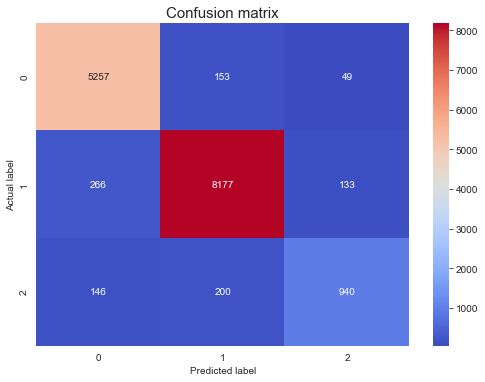

In [32]:
# Plot Confusion matrix
label_names=[0,1,2]
fig, ax = plt.subplots(figsize=(7,5))
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
sns.heatmap(pd.DataFrame(lsa_matrix), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1, fontsize=15)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [33]:
# Classification score
lsa_report = classification_report(
    digits=2,
    y_true=y_test,
    y_pred=gs_lsa.predict(X_test)
)

print(lsa_report)

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      5459
         1.0       0.96      0.95      0.96      8576
         2.0       0.84      0.73      0.78      1286

    accuracy                           0.94     15321
   macro avg       0.91      0.88      0.89     15321
weighted avg       0.94      0.94      0.94     15321



In [34]:
# ROC AUC score
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)

    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    return roc_auc_score(y_test, y_pred, average=average)

multiclass_roc_auc_score(y_test,gs_lsa.predict(X_test))

0.9233902029006998

In [35]:
# Using the best params
pipeline = Pipeline(steps=[('tvec', TfidfVectorizer(stop_words='english')),
                           ('svd', TruncatedSVD(n_components=1000)),
                           ('lr', LogisticRegression(max_iter=1000))])

In [36]:
# Fit the pipeline model with the training data
pipeline.fit(X_train,y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('svd', TruncatedSVD(n_components=1000)),
                ('lr', LogisticRegression(max_iter=1000))])

In [37]:
# Test with sample review
text=['I am so disappointed with JAL charging a cancellation fee on my ticket from Melbourne to Tokyo in this time of crisis. As Australia announced a travel ban on March 17, my family and I had to cancel our trip to Japan. Upon receiving my refund in my account however I noticed that I was short $1200. Upon contacting the JAL Australia office however, I was told that there had been a cancellation fee applied, as my refund was processed 1 day before their policy update.']
pipeline.predict(text)

array([1.])

In [38]:
# Import joblib
#from joblib import dump

In [39]:
# dump the pipeline model
#dump(pipeline, filename="text_classification.joblib", compress=3)

['text_classification.joblib']